In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import cv2 #For image displaying
import random
import pickle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digits-dataset-train/train.csv


In [2]:
import sys
sys.path.append('/kaggle/input/Digits_dataset_train')

# Train Test Split 

In [3]:

def train_test_split(dataset, frac=0.7):
    # Validate the fraction
    if not (0 < frac < 1):
        raise ValueError("The fraction must be between 0 and 1.")
    
    #convert dataset to numpy array
    dataset = np.array(dataset)

    np.random.shuffle(dataset)
    
    #split index finding
    split_index = int(len(dataset) * frac)
    
    #split dataset
    train_set = dataset[:split_index]
    test_set = dataset[split_index:]
    
    X_train = train_set[:,1:]
    y_train = train_set[:,0]
    X_test = test_set[:,1:]
    y_test = test_set[:,0]
    
    return X_train, y_train, X_test, y_test

def Extract(dataset, option = "train"):
    np_data = np.array(dataset)
#     np.random.shuffle(data)
    
        
    y = np_data[:,0]
    X = np_data[:,:]
    
    if option == "train":
        X = X[:,1:]
        y = y[:,0]
    return X,y,dataset
dataset = pd.read_csv("/kaggle/input/digits-dataset-train/train.csv")
X_train, y_train, X_test, y_test = train_test_split(dataset)
# _.head()

In [4]:
print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_test.shape=}")
print(f"{y_test.shape=}")

X_train.shape=(29399, 784)
y_train.shape=(29399,)
X_test.shape=(12601, 784)
y_test.shape=(12601,)


# Classes for different activation functions / layers

In [5]:
class Dense:
    def __init__(self, n_inputs, n_outputs, lr=0.01):
        # Initialize stuff
        self.weights = np.random.randn(n_inputs, n_outputs) * 0.01
        self.biases = np.zeros((1, n_outputs))
        self.lr = lr

    def forward(self, inputs):
        self.inputs = inputs
        
        #z = wx + b
        self.outputs = np.dot(inputs, self.weights) + self.biases
        return self.outputs

    def backpass(self, der_values):
        #Gradient Descent:
        #gradients on parameters (weights and biases)
        self.der_weights = np.dot(self.inputs.T, der_values)
        self.der_biases = np.sum(der_values, axis=0, keepdims=True)
        
        #gradient on the input (for the previous layer)
        self.der_inputs = np.dot(der_values, self.weights.T)

        #update weights and biases
        self.weights -= self.lr * self.der_weights
        self.biases -= self.lr * self.der_biases

        return self.der_inputs

In [6]:
class ReLU:
    def __init__(self):
        None
        
    def forward(self, inputs):
        self.inputs=inputs
        #implementing relu: max(0,input)
        self.outputs = np.maximum(0, inputs)
        return self.outputs
        
    def backpass(self, der_inputs):
        self.der_inputs = der_inputs.copy()
        
        #zeroing out the negative slopes
        self.der_inputs[self.inputs <= 0] = 0
        return self.der_inputs

In [7]:
class Sigmoid:
    def __init__(self):
        None

    def forward(self, inputs):
        #store input for use in the backpass pass
        self.inputs = inputs
        #calculate the sigmoid output
        self.output = 1 / (1 + np.exp(-inputs))

    def backpass(self, dvalues):
        #derivatives of the sigmoid function
        self.dinputs = dvalues * (self.output * (1 - self.output))

In [8]:
class Softmax:
    def forward(self, inputs):
        self.inputs = inputs
        exps = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exps / np.sum(exps, axis=1, keepdims=True)
        return self.output

    def backpass(self, der_vals):
        self.der_inputs = np.empty_like(der_vals)
        for index, (single_output, single_der_values) in enumerate(zip(self.output, der_vals)):
            single_output = single_output.reshape(-1, 1)
            jacobian = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.der_inputs[index] = np.dot(jacobian, single_der_values)
        return self.der_inputs

In [9]:
class CatCrossEntropyLoss:
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        
        
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
            
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
            
        negative_log_likelihoods = -np.log(correct_confidences)
        loss = np.mean(negative_log_likelihoods)
        return loss
    
    
    def backpass(self, y_pred, y_true):
        samples = len(y_pred)
        labels = len(y_pred[0])
        
        
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
            
        y_pred_safe = y_pred + 1e-7
        self.derivatives = -y_true / y_pred_safe
        self.derivatives = self.derivatives / samples
        return self.derivatives

In [10]:
class NN:
    def __init__(self):
        self.layers = []
        self.loss_func = CatCrossEntropyLoss()
        self.losses = []
        
    def addLayer(self, layer):
        self.layers.append(layer)
    
    def forward(self, X):
        for l in self.layers:
            X = l.forward(X)
        return X
    def backpass(self, der_vals):
        for l in self.layers[::-1]:
            der_vals = l.backpass(der_vals)
    
    def train(self, X, y, n_epochs):
        for i in range(n_epochs):
            output = self.forward(X)
            loss = self.loss_func.forward(output, y)
            derivatives = self.loss_func.backpass(output, y)
            self.backpass(derivatives)
            
            print(f"=== Loss: {loss:.4f} -- epoch {i=}===")
            self.losses.append(loss)
            
        print("Training Loss:")
        self.evaluate(X,y)
        
        
        
    def predict(self, x):
        output = self.forward(x)
        # Ensure output is at least 1D
        if output.ndim == 0:
            output = np.array([output])
        return output
            
#     def evaluate(self, x_test, y_test):
#         y_pred = self.predict(x_test)
#         print(f"{y_pred=}")
#         print(f"{y_test=}")
        
#         accuracy = self.compute_accuracy(y_pred, y_test)
# #         self.matches = (y_pred == y_test).astype(np.int32)
# #         self.accuracy = np.mean(self.matches)
# #         print(self.matches)
# #         return self.accuracy
    
# #         self.true_postitives = []
# #         for i in range(y_test.shape[0]):
# #             if y_pred == y_test[i]:
# #                 self.true_postitives.append(1)
# #             else:
# #                 self.true_postitives.append(0)


    def evaluate(self, x_test, y_test):
        y_pred = self.predict(x_test)
        

        if y_pred.ndim == 0:
            y_pred = np.expand_dims(y_pred, axis=0)
        
        #accuracy:
        accuracy = self.compute_accuracy(y_pred, y_test)
        print(f"Accuracy: {accuracy:.4f}")
        
        #loss:
        loss = self.loss_func.forward(y_pred, y_test)
        print(f"Loss: {loss:.4f}")
        
        return loss, accuracy
    
    def compute_accuracy(self, y_pred, y_test):
        y_test_labels = y_test
        
        
        #convert y_pred to class labels
#         print(y_pred)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        #calculate accuracy
        accuracy = np.mean(y_pred_labels == y_test_labels)
        
        return accuracy
    
    def save_weights(self, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump(self.layers, f)
        print(f"Weights saved to {filepath}")
        
    def load_weights(self, filepath):
        with open(filepath, 'rb') as f:
            self.layers = pickle.load(f)
        print(f"Weights loaded from {filepath}")

# Adding the layers

In [11]:
model = NN()
model.addLayer(Dense(784, 128, 0.01))
model.addLayer(ReLU())
model.addLayer(Dense(128, 128, 0.01))
model.addLayer(ReLU())
model.addLayer(Dense(128, 10, 0.01))
model.addLayer(Softmax())

In [12]:
no_eps = 100
model.train(X_train, y_train, no_eps)
print("\n\n")
print("Testing Loss:")
model.evaluate(X_test, y_test)

=== Loss: 2.3112 -- epoch i=0===
=== Loss: 2.2527 -- epoch i=1===
=== Loss: 2.1997 -- epoch i=2===
=== Loss: 2.1420 -- epoch i=3===
=== Loss: 2.0738 -- epoch i=4===
=== Loss: 1.9915 -- epoch i=5===
=== Loss: 1.8922 -- epoch i=6===
=== Loss: 1.7748 -- epoch i=7===
=== Loss: 1.6409 -- epoch i=8===
=== Loss: 1.4962 -- epoch i=9===
=== Loss: 1.3498 -- epoch i=10===
=== Loss: 1.2121 -- epoch i=11===
=== Loss: 1.0908 -- epoch i=12===
=== Loss: 0.9889 -- epoch i=13===
=== Loss: 0.9061 -- epoch i=14===
=== Loss: 0.8514 -- epoch i=15===
=== Loss: 1.0082 -- epoch i=16===
=== Loss: 2.5540 -- epoch i=17===
=== Loss: 2.6841 -- epoch i=18===
=== Loss: 1.7886 -- epoch i=19===
=== Loss: 1.4737 -- epoch i=20===
=== Loss: 1.2942 -- epoch i=21===
=== Loss: 1.1759 -- epoch i=22===
=== Loss: 1.0632 -- epoch i=23===
=== Loss: 0.9523 -- epoch i=24===
=== Loss: 0.8502 -- epoch i=25===
=== Loss: 0.7650 -- epoch i=26===
=== Loss: 0.7007 -- epoch i=27===
=== Loss: 0.6525 -- epoch i=28===
=== Loss: 0.6157 -- epoc

(0.310546476682965, 0.9073089437346242)

Weights saved to /kaggle/working/test_weights_save.pkl


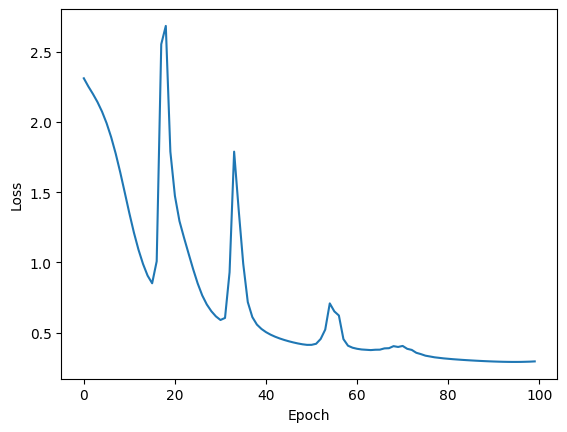

In [13]:
plt.plot(range(no_eps), model.losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
model.save_weights("/kaggle/working/test_weights_save.pkl")


##  For Predicting random samples

In [14]:
def display_image(image_vector):
    #reshaping
    image_array = image_vector.reshape((28, 28))
    
    #displaying
    plt.imshow(image_array, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.show()


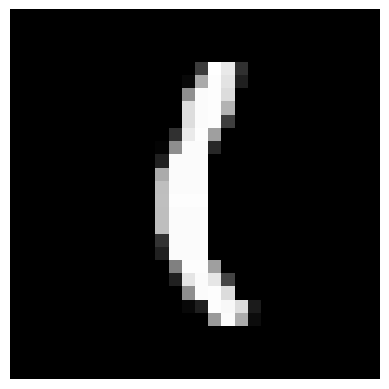

Prediction:  1


In [15]:
RAND_VAL = random.randint(0, X_test.shape[0]) 
img = X_train[RAND_VAL, :]
display_image(img)
print("Prediction: ",np.argmax(model.predict(img)))